In [499]:
import sys 
import pandas as pd
from datetime import datetime, timedelta
import glob, os

# 기본 플롯 설정

In [289]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
print(plt.rcParams['font.family'])

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

warnings.filterwarnings('ignore')

# 폰트 설정 방법 1

# matplotlib 폰트설정
# plt.rc('font', family='NanumGothicOTF') # For MacOS
# plt.rc('font', family='NanumGothic')


['NanumGothic']


# pymysql로 연결

In [ ]:
import yaml
with open('./config/config.yml') as f:
    conf = yaml.load(f, Loader=yaml.FullLoader)['mysql']
    host=conf['host'] 
    user=conf['user'] 
    passwd=conf['passwd'] 
    port=conf['port']

In [ ]:
# import the mysql client for python

import pymysql
			
database = "sample"
database=database
conn = pymysql.connect(host=host, 
                       user=user, 
                       password=passwd, 
                       database=database, 
                       port=port)

cur = conn.cursor()


## 데이터 DB에 읽기/쓰기

In [ ]:
from sqlalchemy import create_engine

db_connection_str = f'mysql+pymysql://{user}:{passwd}@{host}/{database}'
db_connection = create_engine(db_connection_str)
conn_ = db_connection.connect()

In [ ]:
from sqlalchemy import engine
# 접속 url 만들어줌
engine.url.URL(drivername='mysql+pymysql', username=user, password=passwd, host=host, database=database)

In [ ]:
# 데이터 읽기

q='''
select *
from listenbrainz
limit 0,10
'''
pd.read_sql(sql=q,
            con=db_connection, 
            parse_dates=["date_column"])



# 데이터 넣기
''' 
sample_df.to_sql(name='listenbrainz', # .iloc[18511:18512] 
          con=db_connection, 
          #if_exists='replace',
          if_exists='append',
          index=False)
'''

In [ ]:
q='''
show variables like '%time_zone%';
'''
cur.execute(q)
print(f"{cur.rowcount} details inserted")
rst = cur.fetchall()
conn.commit()
rst
#conn.close()

모든 데이터 파일 확인하는 작업인데 안쓰면 삭제

In [ ]:
# 큰 데이터 나눠가져오기
chunksize = 10**4


csv_files = glob.glob("../DE/listenBrainz_data_201501_to_201605/*.csv")
# "../DE/listenBrainz_data_201501_to_201605/bq-results-20220209-20150101-20150531.csv"
tags_basket = [] 
for f in csv_files:
    earliest_t = None
    last_t = None
    csv_chunk = pd.read_csv(f,chunksize=chunksize)

    num_lines = 0
    test_chunk = None
    tags_nan_check = 0

    for i, chunk in enumerate(csv_chunk) :
        chunk = chunk.set_index('listened_at')
        earliest_t = chunk.index.min() if not earliest_t else min(earliest_t, chunk.index.min())
        last_t = chunk.index.max() if not last_t else max(last_t, chunk.index.max())
        num_lines += chunksize 

        try:
            tags_nan_check += chunk.tags.isna().count() 
            tags_basket.extend(list(chunk[chunk.tags.notna()]['tags']))
            # 시간 체크
            #piece = chunk.loc['2015-01-01 13:17':'2015-01-01 13:18']
            #if piece.shape[0] >0:
            #    pass
                #print(f"{i}th : ")
                #print(piece)

        except Exception as e:
            print(e)
        if i ==0:
            test_chunk = chunk

    print(f'file_name: {os.path.basename(f)}')
    print(f'- from {earliest_t} to {last_t}')
    print(f'- # of lines : {num_lines}')
    print(f'- # of NaN in tags : {tags_nan_check} ({round(tags_nan_check*100/num_lines, 2)}%)') 
    print()

## - 일 지정 데이터 얻는 함수 

In [ ]:
f_ =  "../DE/listenBrainz_data_201501_to_201605/bq-results-20220209-20170901_20171231.csv"
chunksize = 10**4

def get_dataframe(f_path, start_t, period=30, chunksize=10**4):
    """
    f_path: 파일 경로
    start_t: 데이터 시작날짜
    period: 시작날짜 이후 가져올 일수 (ex. start_t: 2017-09-02, period:2 => 데이터 마지막 날짜: 2017-09-04)
    """
    
    os.path.basename(f_path).split('-')[-1].split('_')   
    csv_chunk = pd.read_csv(f_path, chunksize=chunksize)

    num_lines = 0 # 라인 몇 개인지 세기
    test_chunk = None
    sample_df = pd.DataFrame()
    #if not start_t:
    #    start_t = '2017-09-01'
    next_day = (datetime.strptime(start_t, '%Y-%m-%d')+ timedelta(days=period)).strftime('%Y-%m-%d 00:00:00 UTC')

    for i, chunk in enumerate(csv_chunk) :
        
        # 날짜 검색 편하게 index 설정
        chunk = chunk.set_index('listened_at')
        
        # 다음 날 데이터가 시작되면 for문을 멈춘다
        # 지정 날짜보다 전 날짜이면 skip
        # 데이터가 날짜 순서대로 들어가있는 것이 아니어서 두 조건 다 continue로 설정해주었다.
        if chunk.index[0] >= next_day: continue 
        if chunk.index[-1] < start_t: continue 
        
        try:
            # 데이터 concat
            sample_df = pd.concat([sample_df, chunk.loc[start_t+' 00:00:00 UTC':next_day]])
        except Exception as e:
            print(e)
            
        if i ==0:
            test_chunk = chunk

    return test_chunk, sample_df.reset_index()
    

### - 2017-09 데이터를 가져오기

In [491]:
test, _ = get_dataframe(f_, start_t='2017-09-01', period=1)
test.head()

,user_name,artist_name,artist_msid,release_name,release_msid,track_name,recording_msid,tags
listened_at,,,,,,,,
2017-09-01 00:00:06 UTC,braydenmclellan,Small Black,3e1256e3-4183-4dc5-bf90-ad1c9b0c8eb3,NaN,NaN,Search Party,56177420-d17d-47dd-83d9-9bcde19cbb5d,NaN
2017-09-01 00:00:09 UTC,user18081971,Slowdive,f69942be-bccd-44eb-8962-2e5025507196,Souvlaki,f8a36f48-65d3-4369-9c2d-f641f17f458b,Souvlaki Space Station,69ea7fb7-6df8-403c-8748-fcb0827d1fb4,NaN
2017-09-01 00:00:10 UTC,zimonledemon,The Kinks,b76996af-1dce-4fa7-839a-42f2b781dfa2,NaN,9fb96da2-519a-49bc-8240-434e9118add5,Waterloo Sunset - Mono Version,425a1718-5186-4c4e-a5c5-8f78479db6fa,NaN
2017-09-01 00:00:17 UTC,whygottalogin,Pop Will Eat Itself,edd660e7-70a5-4385-ac87-1a773b806891,NaN,8c4a6d2d-b215-4d1a-831a-9feefc1e94e0,Poison To The Mind,9cef0949-f02a-4bfe-b4f4-ce12910a7853,NaN
2017-09-01 00:00:18 UTC,I_am_walking,A Victim Of Society,618341c5-6ef6-43e8-89a6-a2b0d6865f4b,NaN,NaN,The Revolution Will Not Be Televised (Gil Scot...,173ff0a9-25d9-449c-8646-6070305acf81,NaN


In [252]:
test, test_2 = get_dataframe(f_, start_t='2017-09-01')
test_2.head()

,user_name,artist_name,artist_msid,release_name,release_msid,track_name,recording_msid,tags
listened_at,,,,,,,,
2017-09-01 00:00:06+00:00,braydenmclellan,Small Black,3e1256e3-4183-4dc5-bf90-ad1c9b0c8eb3,NaN,NaN,Search Party,56177420-d17d-47dd-83d9-9bcde19cbb5d,NaN
2017-09-01 00:00:09+00:00,user18081971,Slowdive,f69942be-bccd-44eb-8962-2e5025507196,Souvlaki,f8a36f48-65d3-4369-9c2d-f641f17f458b,Souvlaki Space Station,69ea7fb7-6df8-403c-8748-fcb0827d1fb4,NaN
2017-09-01 00:00:10+00:00,zimonledemon,The Kinks,b76996af-1dce-4fa7-839a-42f2b781dfa2,NaN,9fb96da2-519a-49bc-8240-434e9118add5,Waterloo Sunset - Mono Version,425a1718-5186-4c4e-a5c5-8f78479db6fa,NaN
2017-09-01 00:00:17+00:00,whygottalogin,Pop Will Eat Itself,edd660e7-70a5-4385-ac87-1a773b806891,NaN,8c4a6d2d-b215-4d1a-831a-9feefc1e94e0,Poison To The Mind,9cef0949-f02a-4bfe-b4f4-ce12910a7853,NaN
2017-09-01 00:00:18+00:00,I_am_walking,A Victim Of Society,618341c5-6ef6-43e8-89a6-a2b0d6865f4b,NaN,NaN,The Revolution Will Not Be Televised (Gil Scot...,173ff0a9-25d9-449c-8646-6070305acf81,NaN


날짜 column datetime 으로 설정

In [ ]:
test_2 = test_2.reset_index()
test_2['listened_at_'] = pd.to_datetime(test_2['listened_at'])
test_2 = test_2.set_index('listened_at')
test_2 = test_2.sort_values(by='listened_at_') # 날짜순 정렬 

'''
- 원 데이터가 날짜정렬이 되어있지 않아 데이터프레임의 날짜도 정렬되어 있지 않다. 
- 데이터를 가져오는 함수에서는 concat을 해서 데이터를 붙이기 때문.
'''

In [498]:
test_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1185627 entries, 2017-09-01 00:00:06+00:00 to 2017-09-30 23:59:59+00:00
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype              
---  ------          --------------    -----              
 0   user_name       1185627 non-null  object             
 1   artist_name     1185627 non-null  object             
 2   artist_msid     1185627 non-null  object             
 3   release_name    430764 non-null   object             
 4   release_msid    1135482 non-null  object             
 5   track_name      1185627 non-null  object             
 6   recording_msid  1185627 non-null  object             
 7   tags            2644 non-null     object             
 8   listened_at_    1185627 non-null  datetime64[ns, UTC]
 9   t_diff          40944 non-null    timedelta64[ns]    
 10  t_diff_shift    32888 non-null    timedelta64[ns]    
dtypes: datetime64[ns, UTC](1), object(8), timedelta64[ns](2)
memory usage:

In [254]:
test_2.tail() 

,user_name,artist_name,artist_msid,release_name,release_msid,track_name,recording_msid,tags
listened_at,,,,,,,,
2017-09-20 18:08:27+00:00,sirfragsmore,Andy James,f42fb557-824d-4543-a028-65b1b6a24324,NaN,aabbb8f3-64aa-4135-a744-9f1d7d9bd216,Burn It Down,dc00be37-d978-45b6-a5f1-7c1e0f692c56,NaN
2017-09-20 18:08:33+00:00,Andreas014,Cat Pierce,9fd86a0a-b6d6-4f20-ac9a-32b7e57175dd,NaN,5989fcab-e149-44cf-bd2b-444e013afd48,You Belong to Me,81b76ab7-32ce-417c-ae3a-fa51ea8d30dd,NaN
2017-09-20 18:08:34+00:00,perceival,Amy Winehouse,db5f18d9-0319-4a0d-bc75-08354b92bff5,Frank (Deluxe Edition),72c3317d-ef2e-453b-b155-3b4f042ce1c2,Mr Magic (Through The Smoke) (Janice Long Sess...,8d733d38-546b-4fc9-b156-c5d212405b28,NaN
2017-09-20 18:08:34+00:00,ivanbarram,Graham Central Station,45f1e6d5-2eb3-411a-8a90-5ef73f56fdce,NaN,7c99fe79-8a11-48ca-87ab-85674725c5dc,The Jam,46992785-3170-4f4a-a3c1-4cacb73b0464,NaN
2017-09-20 18:08:34+00:00,sixteenpsyche,Grimes,8066ffbe-837a-42ca-9a23-8683efe1ed00,NaN,0953826e-e13a-423f-aa92-785b9f887b87,California,c996b260-dedb-480e-8ec4-66ad7c2bd667,NaN


In [ ]:
test_2.head()

In [ ]:
# resample보다 더 좋은 방법을 찾아서.
# test_2.user_name.resample('1T').groupby.count
#test_2 = test_2.reset_index()

---

# [ 집계작업을 하기 위한 데이터 분석 ]
- 플레이된 artist의 재생수 , 가장 많이 재생된 곡, 평균 재생시간 등을 얻기 위해 데이터 탐색
- 전처리해줘야 하는 데이터들 살펴보자
  - 몇 초 이상 트랙이 변경되지 않아야 들었다고 판단할 것인가? 10초 이상?
  - 이상치들을 따로 모을 것인가?

---

### - * 시간간격으로 데이터 묶기. (sql의 윈도우 함수)

<br>
밑에 처럼 카운트하게 되면 단순히 기준 시간 freq(여기선 1T=1분)안에 포함되어 있는 행의 값이 비어있냐 아니냐만 따져서 카운트를 해버린다. <br>
그래서 기준시간 freq=1T, user_name으로 그룹했을 때 유니크한 artist_name 갯수, track_msid 갯수를 세서 따로 t의 행으로 추가한다 <br>
<br>

In [486]:
t = test_2.groupby([pd.Grouper(freq='1T'), 'user_name']).count()
t['unique_artist_count'] = test_2.groupby([pd.Grouper(freq='1T'), 'user_name']).artist_name.nunique()
t['unique_track_count'] = test_2.groupby([pd.Grouper(freq='1T'), 'user_name']).recording_msid.nunique()

<br>

기준freq(=1T)동안 1명의 아티스트의 한 곡을 4번 이상 플레이한 유저 데이터
- 데이터를 보면 같은 초에 계속 트랙이 바뀌는걸 보아 그냥 무작위클릭을 한 것 같이 보인다.

In [489]:
cond_1 = np.where((t['unique_artist_count']==1) & (t['unique_track_count']==1) & (t['track_name']>=4))
repeat_plays = (t[['unique_artist_count', 'unique_track_count', 'track_name']]
                .iloc[cond_1])

repeat_plays.sort_values(by='track_name')

,,unique_artist_count,unique_track_count,track_name
listened_at,user_name,,,
2017-09-29 03:44:00+00:00,Splash777,1,1,4
2017-09-21 04:30:00+00:00,kubeast,1,1,4
2017-09-14 10:56:00+00:00,aprilmendez,1,1,4
2017-09-21 10:40:00+00:00,aprilmendez,1,1,4
2017-09-21 19:26:00+00:00,rinkjames,1,1,4
...,...,...,...,...
2017-09-15 15:05:00+00:00,gandolforf,1,1,25
2017-09-15 19:35:00+00:00,sixteenpsyche,1,1,28
2017-09-26 23:39:00+00:00,fuleirarecords,1,1,29


<br>
위의 user중 몇을 검사해보자

In [500]:
test_2[test_2['user_name']=='aprilmendez'].loc['2017-09-14 10:56']

,user_name,artist_name,artist_msid,release_name,release_msid,track_name,recording_msid,tags,listened_at_,t_diff,t_diff_shift
listened_at,,,,,,,,,,,
2017-09-14 10:56:05+00:00,aprilmendez,Bonobo,2921a1a4-70d8-4e90-9857-2188f6fa1782,NaN,2562fa16-7220-4b03-9770-44f4b73e257c,The Shark,8c9961db-4a55-4520-a7d1-92a5c5eca72e,NaN,2017-09-14 10:56:05+00:00,NaT,0 days 00:00:01
2017-09-14 10:56:06+00:00,aprilmendez,Bonobo,2921a1a4-70d8-4e90-9857-2188f6fa1782,NaN,2562fa16-7220-4b03-9770-44f4b73e257c,The Shark,8c9961db-4a55-4520-a7d1-92a5c5eca72e,NaN,2017-09-14 10:56:06+00:00,0 days 00:00:01,0 days 00:00:01
2017-09-14 10:56:07+00:00,aprilmendez,Bonobo,2921a1a4-70d8-4e90-9857-2188f6fa1782,NaN,2562fa16-7220-4b03-9770-44f4b73e257c,The Shark,8c9961db-4a55-4520-a7d1-92a5c5eca72e,NaN,2017-09-14 10:56:07+00:00,0 days 00:00:01,0 days 00:00:04
2017-09-14 10:56:11+00:00,aprilmendez,Bonobo,2921a1a4-70d8-4e90-9857-2188f6fa1782,NaN,2562fa16-7220-4b03-9770-44f4b73e257c,The Shark,8c9961db-4a55-4520-a7d1-92a5c5eca72e,NaN,2017-09-14 10:56:11+00:00,0 days 00:00:04,NaT


In [501]:
test_2[test_2['user_name']=='Balinsky'].loc['2017-09-07 18:38']#[['t_diff']]

,user_name,artist_name,artist_msid,release_name,release_msid,track_name,recording_msid,tags,listened_at_,t_diff,t_diff_shift
listened_at,,,,,,,,,,,
2017-09-07 18:38:09+00:00,Balinsky,Capa,b629ce40-0ea2-456a-b9bd-67c2567006a4,NaN,NaN,"Masquerade, Pt. 2",355668d0-5ff7-4c6a-8e8d-198bbe7bc3e0,NaN,2017-09-07 18:38:09+00:00,NaT,0 days
2017-09-07 18:38:09+00:00,Balinsky,Parov Stelar,ce473fa5-b725-4e11-a595-ef36211687b6,NaN,NaN,Chambermaid Swing,ba1ee7bb-6be8-4ca8-af85-d53e7509ce7e,NaN,2017-09-07 18:38:09+00:00,0 days,0 days
2017-09-07 18:38:09+00:00,Balinsky,Ravin,0350a483-d23d-4943-9d86-e8da607454f7,NaN,NaN,Romance in Klotild Palace,5b33ac1a-0dab-4f63-9d36-36a41d270cb9,NaN,2017-09-07 18:38:09+00:00,0 days,0 days
2017-09-07 18:38:09+00:00,Balinsky,عمر دياب,058ee71d-42d4-41eb-93ec-d2af2c3a29a5,NaN,NaN,Weghalawtac,82bb3659-ab48-40e3-a73d-772e30ee3705,NaN,2017-09-07 18:38:09+00:00,0 days,0 days
2017-09-07 18:38:09+00:00,Balinsky,Fragile State,ec409f3d-2a19-4613-a67f-e7dad4ffce00,NaN,NaN,Song of Departure,6d611818-02c0-4b78-949b-4f802b1ac415,NaN,2017-09-07 18:38:09+00:00,0 days,0 days
2017-09-07 18:38:09+00:00,Balinsky,"Chris Le Blanc, Miss Luna",d84b85b2-53dd-4fcc-a493-d193415f38c1,NaN,NaN,Le soleil ou la lune (feat. Oceane),a54ea8ed-130e-425a-8d57-d34161625571,NaN,2017-09-07 18:38:09+00:00,0 days,0 days
2017-09-07 18:38:09+00:00,Balinsky,Kirpi,b32293e0-73ba-413d-8e7b-e3937d49d07a,NaN,NaN,The song,a90ea638-0f4f-4efb-b3b1-6af19d5015a7,NaN,2017-09-07 18:38:09+00:00,0 days,0 days
2017-09-07 18:38:09+00:00,Balinsky,Dego Lounge,b70e8ded-781e-4088-b1e1-211cc3f33925,NaN,NaN,Plume,b3ccfbde-12e6-416b-9b0a-52567b1f8778,NaN,2017-09-07 18:38:09+00:00,0 days,0 days
2017-09-07 18:38:09+00:00,Balinsky,Mari Boine,c327fcde-2930-4299-8026-5c13adb9cc10,NaN,NaN,Maid of Aiggot Muimma Eallin,0dd6af5c-8f1d-47e5-8f0f-019665690f86,NaN,2017-09-07 18:38:09+00:00,0 days,0 days


In [495]:
test_2[test_2['user_name']=='CatCat'].loc['2017-09-01 00:02']

,user_name,artist_name,artist_msid,release_name,release_msid,track_name,recording_msid,tags,listened_at_,t_diff,t_diff_shift
listened_at,,,,,,,,,,,
2017-09-01 00:02:19+00:00,CatCat,Antonio de Salazar,7cbc38ab-99d2-4b8b-974a-eeab820b4446,NaN,3f482b55-bc6a-44db-ab81-ee3455e77a22,Tarará qui yo soy Antoniyo,8de50475-83d5-4de4-97d3-6fa485cdcb38,NaN,2017-09-01 00:02:19+00:00,NaT,0 days 00:00:01
2017-09-01 00:02:20+00:00,CatCat,Thomas Från Sverige,70ba3533-0a00-4504-9d3c-b9382353971e,NaN,0283513e-f8aa-445d-8b14-573077fdf615,Skulle Island,125b20ef-24c8-4232-9c3d-d6cf2843f24f,NaN,2017-09-01 00:02:20+00:00,0 days 00:00:01,0 days 00:00:32
2017-09-01 00:02:52+00:00,CatCat,Thomas Från Sverige,70ba3533-0a00-4504-9d3c-b9382353971e,NaN,0283513e-f8aa-445d-8b14-573077fdf615,Guvenör Phatt,cb7959e5-904f-4be6-a4b8-412a95b475c9,NaN,2017-09-01 00:02:52+00:00,0 days 00:00:32,NaT


In [496]:
test_2[test_2['user_name']=='thespeckofme'].loc['2017-09-02 02:36']

,user_name,artist_name,artist_msid,release_name,release_msid,track_name,recording_msid,tags,listened_at_,t_diff,t_diff_shift
listened_at,,,,,,,,,,,
2017-09-02 02:36:27+00:00,thespeckofme,DMX,d8925574-7b59-4a5c-91da-7b005bc25a88,NaN,7a0dc963-0f90-4195-8382-e1c8b2bd4884,X Gon' Give It To Ya,e61e2c66-12dc-44ab-b035-1ae177c98cc3,NaN,2017-09-02 02:36:27+00:00,NaT,0 days 00:00:01
2017-09-02 02:36:28+00:00,thespeckofme,DMX,d8925574-7b59-4a5c-91da-7b005bc25a88,NaN,7a0dc963-0f90-4195-8382-e1c8b2bd4884,X Gon' Give It To Ya,e61e2c66-12dc-44ab-b035-1ae177c98cc3,NaN,2017-09-02 02:36:28+00:00,0 days 00:00:01,NaT
2017-09-02 02:36:29+00:00,thespeckofme,DMX,d8925574-7b59-4a5c-91da-7b005bc25a88,NaN,7a0dc963-0f90-4195-8382-e1c8b2bd4884,X Gon' Give It To Ya,e61e2c66-12dc-44ab-b035-1ae177c98cc3,NaN,2017-09-02 02:36:29+00:00,NaT,0 days 00:00:01
2017-09-02 02:36:30+00:00,thespeckofme,DMX,d8925574-7b59-4a5c-91da-7b005bc25a88,NaN,7a0dc963-0f90-4195-8382-e1c8b2bd4884,X Gon' Give It To Ya,e61e2c66-12dc-44ab-b035-1ae177c98cc3,NaN,2017-09-02 02:36:30+00:00,0 days 00:00:01,0 days 00:00:01
2017-09-02 02:36:31+00:00,thespeckofme,DMX,d8925574-7b59-4a5c-91da-7b005bc25a88,NaN,7a0dc963-0f90-4195-8382-e1c8b2bd4884,X Gon' Give It To Ya,e61e2c66-12dc-44ab-b035-1ae177c98cc3,NaN,2017-09-02 02:36:31+00:00,0 days 00:00:01,0 days 00:00:01
2017-09-02 02:36:32+00:00,thespeckofme,DMX,d8925574-7b59-4a5c-91da-7b005bc25a88,NaN,7a0dc963-0f90-4195-8382-e1c8b2bd4884,X Gon' Give It To Ya,e61e2c66-12dc-44ab-b035-1ae177c98cc3,NaN,2017-09-02 02:36:32+00:00,0 days 00:00:01,NaT


---

<br>
sql의 partition by 작업. 이미 groupby한 곳에다 컬럼을 추가하겠다고 많이 헤맸다..

In [492]:
test_2['t_diff'] = test_2.groupby([pd.Grouper(freq='1T'), 'user_name']).listened_at_.diff()#.fillna(0.0) #에러남!
# TypeError: value should be a 'Timedelta', 'NaT', or array of those. Got 'float' instead.

In [493]:
test_2['t_diff_shift'] = test_2.groupby([pd.Grouper(freq='1T'), 'user_name'])['t_diff'].shift(-1)

In [463]:
# diff 타입 확인
test_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1185627 entries, 2017-09-01 00:00:06+00:00 to 2017-09-30 23:59:59+00:00
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype              
---  ------          --------------    -----              
 0   user_name       1185627 non-null  object             
 1   artist_name     1185627 non-null  object             
 2   artist_msid     1185627 non-null  object             
 3   release_name    430764 non-null   object             
 4   release_msid    1135482 non-null  object             
 5   track_name      1185627 non-null  object             
 6   recording_msid  1185627 non-null  object             
 7   tags            2644 non-null     object             
 8   listened_at     1185627 non-null  datetime64[ns, UTC]
 9   listened_at_    1185627 non-null  datetime64[ns, UTC]
 10  t_diff          40944 non-null    timedelta64[ns]    
dtypes: datetime64[ns, UTC](2), object(8), timedelta64[ns](1)
memory usage:

# ---------------------

## 잠깐 쉬어가는? 타임. ph15h 그는 누구인가
- hoxy 하이어뮤직의 그?
- 2017-09-02데이터 처음에 ph15h 유저가 제이팍의 몸매를 플레이한 것, 
- 유저네임의 ph1..ph1이라는 래퍼겸 프로듀서가 있고, 그는 제이퐉이 주축인 하이어뮤직에 몸담고 있어서 갑자기 호기심이 일었음..
- 재미로 해봄. 유저가 많을 텐데 그라고 단정하긴 좀.

그의 2017-09월 플레이 리스트를 살펴보자

In [262]:
ph15h_data = pd.DataFrame(t.loc[:,'ph15h',:].index.to_list(), columns=['listened_at','user_name','track_name', 'artist_name'])

In [263]:
ph15h_data = ph15h_data.set_index('listened_at')

In [265]:
ph15h_data.head()
#temp = ph15h_data.groupby(['artist_name']).count().sort_values(by='listened_at')[['listened_at']]

,user_name,track_name,artist_name
listened_at,,,
2017-09-01 03:34:00+00:00,ph15h,Bad and Boujee (Feat. Lil Uzi Vert),Migos
2017-09-01 03:40:00+00:00,ph15h,It Ain't Me,Kygo & Selena Gomez
2017-09-01 03:44:00+00:00,ph15h,Don't Let Me Down (Illenium Remix) (feat. Daya),The Chainsmokers
2017-09-01 03:47:00+00:00,ph15h,Numb/Encore,Jay-Z and Linkin Park
2017-09-01 03:51:00+00:00,ph15h,I will show you(보여줄게),Ailee(에일리)


그의 9월 플레이한 아티스트 랭킹 30
- 전체적으로도 한국인 아티스트가 꽤 보임. 태양은 글로벌하진 않지 않나? 아무래도.
- 랭킹에서 다수의 한국인(제이퐉 2위, 에일리, 태연,쥐드래곤..), 힙합장르를 하는 외국 아티스트들

<AxesSubplot:title={'center':'2017-09: ph15h가 많이 들은 아티스트 랭킹'}, ylabel='artist_name'>

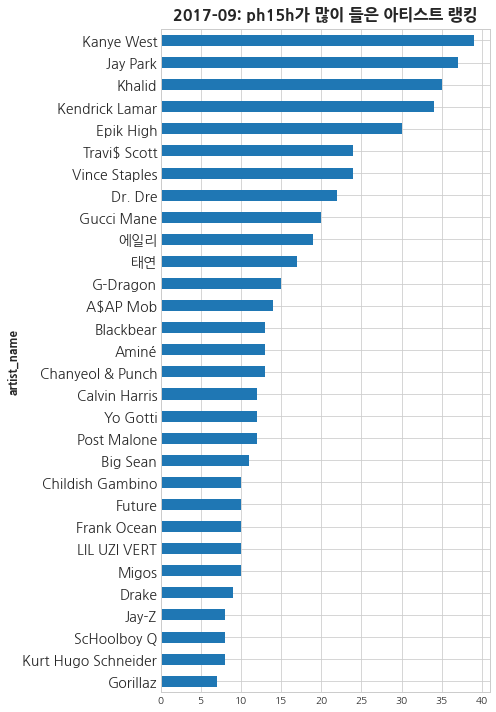

In [303]:
ph1_count = ph15h_data.groupby('artist_name').count().sort_values(by='user_name')[-30:]
plt.yticks(fontsize=14)
ph1_count['user_name'].plot(kind='barh', 
                            figsize=(7,10), 
                            title='2017-09: ph15h가 많이 들은 아티스트 랭킹')


In [272]:
ph15h_data_g = ph15h_data.groupby([pd.Grouper(freq='1D'),'artist_name']) # 

In [273]:
ph15h_data_g.count()

user_name  track_name
listened_at               artist_name                          
2017-09-01 00:00:00+00:00 50 Cent                 4           4
                          Ailee(에일리)              1           1
                          Ariana Grande           1           1
                          B.o.B                   1           1
                          Beyoncé                 1           1
...                                             ...         ...
2017-09-30 00:00:00+00:00 Run the Jewels          1           1
                          Travi$ Scott            1           1
                          Vince Staples           2           2
                          Yo Gotti                1           1
                          태연                      1           1

[536 rows x 2 columns]

# 멀티프로세스

In [ ]:
import multiprocessing as mp

def parallel_dataframe(df, func):
    global num_cores
    df_split = np.array_split(df, num_cores)
    pool = mp.Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [ ]:
mp.cpu_count()

In [ ]:
d = {'col1': [1, 2], 'col2': [3, 4]}
df = pd.DataFrame(d)

In [ ]:
df.to_dict(orient='split')['data']

In [ ]:
from multiprocessing import Pool

def f(x,y):
    return x*y
with Pool(processes=4) as pool:         # start 4 worker processes
    result = pool.starmap_async(f, [[10,20],[20,20],[30,20],[40,20],[50,20]])
    print(result.get())

In [ ]:
df = pd.DataFrame({'a':[1,2,None], 'name':['a','b','c']})
df2 = pd.DataFrame({'a':[None,None,3], 'name':['a','b','c']})

cols_to_use = df2.columns.difference(df.columns)

In [ ]:
df.name == df2.name

In [ ]:
np.where((df.name == df2.name) & (df.a.isnull() | df.a.isna()), df2.a, df.a)